Find Players with low potentials but high actual Rating
- Label Players with a Rating under 75 as False
- Label the players as True who reach a high potential with at least 85

In [129]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.crawler.fifa import extract_attributes


New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [130]:
FIFA = "2022"
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_prospect = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT MAX(Potential) as max_potential, * FROM fifa  GROUP BY ID )
GROUP BY ID
order by max_potential DESC
"""


In [131]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)


df_prospect = pd.read_sql_query(sql_prospect, conn)
df_prime = pd.read_sql_query(sql_prime, conn)


conn.close()



In [132]:
df_prospect = df_prospect.set_index(['ID','Name'])
df_prime = df_prime.set_index(['ID','Name'])

In [133]:
df_raw = df_prospect.join(df_prime[["prime_age","PrimeOverall"]])
df = df_raw.copy()

In [134]:
best_pos = lambda x: x.split(',')[0]

# Apply the lambda function to the 'Age' column and create a new column 'SquaredAge'
df["best_poistion"] = df['Position'].apply(best_pos)
df["best_poistion"].value_counts()

best_poistion
CB     9791
ST     8957
CM     6622
GK     6586
CDM    4442
RB     4028
LB     3993
CAM    3858
RM     3106
LM     2995
RW     1503
LW     1342
CF      838
RWB     398
LWB     382
RF       72
LF       66
SW        8
Name: count, dtype: int64

In [135]:
df = df[df.prime_age>df.potential_age]

In [136]:
df = df[(df.Potential>83)]
df['target'] = ((df.max_potential>83)&(df.PrimeOverall<83))

In [137]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target"]]

,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target
ID,Name,,,,,,,,
231747,K. Mbappé,20.0,20.0,22.0,95.0,95.0,89.0,91.0,False
20801,Cristiano Ronaldo,28.0,28.0,31.0,95.0,95.0,92.0,94.0,False
239085,E. Haaland,21.0,21.0,22.0,94.0,94.0,88.0,91.0,False
230621,G. Donnarumma,18.0,18.0,22.0,94.0,94.0,82.0,89.0,False
242444,João Félix,19.0,19.0,22.0,93.0,93.0,80.0,84.0,False
...,...,...,...,...,...,...,...,...,...
50327,S. Pienaar,28.0,28.0,29.0,84.0,84.0,79.0,80.0,True
41874,B. Pedretti,29.0,29.0,30.0,84.0,84.0,78.0,80.0,True
41635,P. Mexès,28.0,28.0,29.0,84.0,84.0,79.0,81.0,True


In [138]:
df.target.value_counts()

target
True     744
False    254
Name: count, dtype: int64

In [139]:
df = df[df.potential_age<25]

In [140]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

In [141]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
df[df.target].describe().round(3).compare(df[~df.target].describe().round(3))



potential_age          max_potential               Age           \
               self    other          self    other     self    other   
count       680.000  155.000       680.000  155.000  680.000  155.000   
mean         20.319   22.174        85.291   87.768   20.319   22.174   
std           1.968    1.632         1.376    2.395    1.968    1.632   
min          16.000   18.000           NaN      NaN   16.000   18.000   
25%          19.000   21.000        84.000   86.000   19.000   21.000   
50%          20.000   23.000        85.000   88.000   20.000   23.000   
75%          22.000   23.000        86.000   89.000   22.000   23.000   
max             NaN      NaN        90.000   95.000      NaN      NaN   

       Overall          Potential            Special          Unnamed: 0  \
          self    other      self    other      self    other       self   
count  680.000  155.000   680.000  155.000   680.000   155.00    680.000   
mean    73.031   80.755    85.291   87.768  1778.112  1939.09  10499.535   
std      4.633    3.393     1.376    2.395   211.609   231.86   2519.242   
min     59.000   69.000       NaN      NaN   903.000  1158.00   2018.000   
25%     70.000   79.000    84.000   86.000  1672.000  1888.50   9126.750   
50%     74.000   81.000    85.000   88.000  1808.000  1978.00  10601.000   
75%     77.000   82.500    86.000   89.000  1922.250  2089.50  12067.500   
max     81.000   89.000    90.000   95.000  2193.000  2295.00  17139.000   

                 Crossing          Finishing          HeadingAccuracy  \
           other     self    other      self    other            self   
count    155.000  680.000  155.000   680.000  155.000         680.000   
mean   12331.284   58.219   64.077    56.213   60.852          56.963   
std     2469.728   16.457   18.185    18.656   21.491          15.708   
min     8437.000    5.000    9.000     3.000    9.000             NaN   
25%    10573.500   51.000   58.000    46.000   50.000          48.000   
50%    11756.000   62.000   69.000    62.000   67.000          59.000   
75%    12906.000   69.000   75.500    70.000   76.000          68.000   
max    17433.000   88.000   87.000    87.000   94.000          86.000   

               ShortPassing           Volleys          Dribbling           \
         other         self    other     self    other      self    other   
count  155.000      680.000  155.000  680.000  155.000   680.000  155.000   
mean    62.929       68.119   74.406   52.574   59.826    67.857   72.581   
std     18.489       11.825   14.017   16.639   19.914    16.927   19.534   
min        NaN       11.000   14.000    4.000    8.000     7.000   10.000   
25%     53.500       64.000   74.000   43.000   50.000    65.000   70.000   
50%     68.000       70.000   77.000   56.000   66.000    73.000   78.000   
75%     76.000       76.000   82.500   65.000   75.500    78.000   85.000   
max     89.000       88.000   89.000   84.000   91.000    91.000   92.000   

         Curve          FKAccuracy          LongPassing          BallControl  \
          self    other       self    other        self    other        self   
count  680.000  155.000    680.000  155.000     680.000  155.000     680.000   
mean    57.218   64.381     49.693   56.232      60.728   68.258      70.354   
std     17.207   20.189     16.745   19.068      13.472   14.431      13.513   
min      5.000   10.000      4.000    8.000      11.000   16.000      10.000   
25%     48.000   56.500     38.000   45.000      53.000   63.500      68.000   
50%     62.000   72.000     51.000   60.000      64.000   73.000      73.000   
75%     69.000   79.000     62.000   71.000      71.000   78.000      78.000   
max     89.000   87.000     91.000   90.000      84.000   87.000      87.000   

               Acceleration          SprintSpeed           Agility           \
         other         self    other        self    other     self    other   
count  155.000      680.000  155.000     680.000  155

In [142]:
df_potentials = df[df.FIFA.between(2021,2024)&(df.Overall<85)&(df.Age<25)&(df.Potential>84)]

In [143]:
df = df[df.FIFA.between(2012,2020)]

In [144]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values()

PrimeOverall          -0.68
Overall               -0.58
max_potential         -0.53
Potential             -0.53
Reactions             -0.49
prime_age             -0.40
potential_age         -0.37
Age                   -0.37
Special               -0.30
Unnamed: 0            -0.29
Composure             -0.25
Vision                -0.25
ShortPassing          -0.22
LongPassing           -0.22
Stamina               -0.21
LongShots             -0.20
ShotPower             -0.19
Curve                 -0.19
FKAccuracy            -0.18
Penalties             -0.17
Crossing              -0.17
Positioning           -0.17
Volleys               -0.17
BallControl           -0.16
Strength              -0.15
Defensive awareness   -0.14
HeadingAccuracy       -0.13
Aggression            -0.13
Dribbling             -0.13
Finishing             -0.12
Interceptions         -0.11
Jumping               -0.11
StandingTackle        -0.08
SprintSpeed           -0.08
SlidingTackle         -0.07
Agility             

In [145]:
if False:
    df[df.target].describe().compare(df[~df.target].describe()).round(2)
    # pot>55
    # -crossing Acceleration SprintSpeed Balance stamina strength
    df.corr()

In [146]:
PLAYER_ATTRIBUTES = [ 'Age','Finishing','Crossing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Aggression',  'Positioning', 'Vision', 'Penalties', 
                      ]
PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [ 'Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

###  Feature Engineering

#### Transform Defense Attributs

In [147]:

if False:
    df['Defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
    df_potentials['Defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)


# PLAYER_ATTRIBUTES.append('Defense')
df_processed = df.copy()
df_potentials = df_potentials[PLAYER_ATTRIBUTES]

#### Transform Value

In [148]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [149]:
df['target'].value_counts()

target
True     424
False    106
Name: count, dtype: int64

In [150]:
df_potentials

,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
252371,J. Bellingham,19.0,66.0,77.0,67.0,84.0,71.0,85.0,68.0,49.0,82.0,84.0,78.0,73.0,81.0,5.0,8.0,79.0,79.0,84.0,79.0,78.0,76.0,89.0,74.0,74.0,85.0,80.0,77.0,84.0,56.0,0.0,78.0,76.0,14.0,11.0,10.0
241096,S. Tonali,20.0,70.0,60.0,69.0,82.0,60.0,76.0,75.0,75.0,81.0,79.0,83.0,78.0,74.0,7.0,7.0,74.0,70.0,74.0,75.0,75.0,63.0,74.0,79.0,70.0,76.0,74.0,60.0,78.0,64.0,0.0,74.0,72.0,13.0,9.0,8.0
231478,L. Martínez,22.0,56.0,86.0,84.0,78.0,83.0,87.0,78.0,43.0,73.0,84.0,84.0,83.0,86.0,8.0,13.0,83.0,56.0,84.0,78.0,80.0,88.0,77.0,83.0,74.0,86.0,45.0,85.0,77.0,74.0,0.0,31.0,44.0,11.0,8.0,8.0
253004,Ansu Fati,17.0,69.0,75.0,58.0,72.0,59.0,79.0,64.0,45.0,69.0,77.0,89.0,87.0,89.0,10.0,7.0,73.0,23.0,70.0,82.0,67.0,73.0,64.0,48.0,70.0,48.0,19.0,68.0,67.0,74.0,0.0,32.0,28.0,6.0,9.0,8.0
246104,R. Gravenberch,19.0,74.0,74.0,58.0,79.0,69.0,83.0,73.0,56.0,78.0,84.0,76.0,78.0,80.0,11.0,12.0,79.0,71.0,73.0,75.0,77.0,72.0,81.0,74.0,78.0,52.0,74.0,72.0,80.0,58.0,0.0,67.0,59.0,12.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240273,E. Smith Rowe,19.0,61.0,63.0,36.0,69.0,55.0,73.0,67.0,58.0,55.0,72.0,79.0,79.0,75.0,8.0,10.0,65.0,37.0,63.0,68.0,69.0,38.0,61.0,44.0,61.0,39.0,24.0,66.0,67.0,64.0,0.0,30.0,31.0,11.0,8.0,14.0
232229,J. Bijlow,23.0,10.0,10.0,11.0,33.0,10.0,11.0,10.0,10.0,44.0,21.0,58.0,55.0,56.0,73.0,78.0,54.0,16.0,75.0,32.0,58.0,67.0,30.0,70.0,10.0,22.0,10.0,10.0,58.0,16.0,0.0,12.0,14.0,80.0,75.0,77.0
231936,B. White,23.0,53.0,22.0,69.0,76.0,21.0,65.0,26.0,20.0,67.0,73.0,69.0,69.0,59.0,5.0,6.0,75.0,78.0,75.0,55.0,39.0,79.0,80.0,74.0,25.0,75.0,78.0,39.0,57.0,24.0,0.0,77.0,78.0,8.0,11.0,12.0


In [151]:
import warnings
from sklearn.model_selection import train_test_split
# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

# Split the data into training and testing sets
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[PLAYER_ATTRIBUTES]
X_test = X_test[PLAYER_ATTRIBUTES]

# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES])
# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=df_potentials.columns)


# Now, you have X_train_scaled_df and X_test_scaled_df with the scaled data and the original index and columns.

df_potentials_scaled_df.head()



,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
252371,J. Bellingham,-0.814941,0.440597,1.072043,0.593750,1.205822,1.032347,0.950809,0.538614,-0.107635,1.425229,0.901954,0.248204,-0.169413,0.629894,-0.570841,-0.382889,1.051336,2.975899,1.752063,0.751220,0.872568,0.830077,1.570628,0.604700,0.880651,1.466016,1.309819,0.890444,1.507799,-0.005434,-1.288525,1.167088,1.203263,0.024922,-0.176798,-0.243647
241096,S. Tonali,-0.310510,0.683369,0.153003,0.718719,1.039149,0.391476,0.421441,0.932748,1.409716,1.352849,0.540968,0.676002,0.293417,0.068138,-0.433046,-0.447440,0.900310,2.581729,0.398921,0.447870,0.655790,-0.329422,0.351690,0.981194,0.654213,0.945275,1.048737,-0.055095,1.054443,0.553091,-1.288525,0.997272,1.031470,-0.041122,-0.316654,-0.392396
231478,L. Martínez,0.698351,-0.166333,1.558594,1.655986,0.705804,1.731479,1.068446,1.101662,-0.457793,0.773813,0.901954,0.761562,0.756247,1.031149,-0.364149,-0.060136,1.172156,1.968576,1.752063,0.675383,1.017087,1.900383,0.595478,1.282389,0.880651,1.523876,-0.213155,1.335404,0.978884,1.251246,-1.288525,-0.828256,-0.171084,-0.173211,-0.386581,-0.392396
253004,Ansu Fati,-1.823802,0.622676,0.963921,0.031390,0.205786,0.333215,0.597897,0.313395,-0.341074,0.484294,0.396574,1.189361,1.126511,1.271902,-0.226354,-0.447440,0.870105,0.523287,-0.142335,0.978732,0.077713,0.562500,-0.460935,-1.353071,0.654213,-0.674807,-1.344506,0.389865,0.223292,1.251246,-1.288525,-0.785802,-0.858258,-0.503434,-0.316654,-0.392396
246104,R. Gravenberch,-0.814941,0.926141,0.909860,0.031390,0.789140,0.915825,0.833171,0.820138,0.300883,1.135711,0.901954,0.077084,0.293417,0.549643,-0.157456,-0.124686,1.051336,2.625526,0.263607,0.447870,0.800309,0.473308,0.920528,0.604700,1.107088,-0.443366,1.048737,0.612344,1.205562,0.134197,-1.288525,0.700093,0.473141,-0.107167,-0.386581,-0.541146


In [152]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    if False:
        try:
            # Interpret the model using SHAP values
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_scaled_df)
            # Save SHAP values to a pickle file
            with open(f"{model_name}_shap_values.pkl", "wb") as file:
                pickle.dump(shap_values, file)
        except:
            print("Fehler bei SHAP",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Decision Tree Classifier training----->
Random Forest Classifier training----->
Support Vector Classifier training----->
XGBoost Classifier training----->
LightGBM Classifier training----->
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 344, number of negative: 80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.811321 -> initscore=1.458615
[LightGBM] [Info] Start training from score 1.458615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

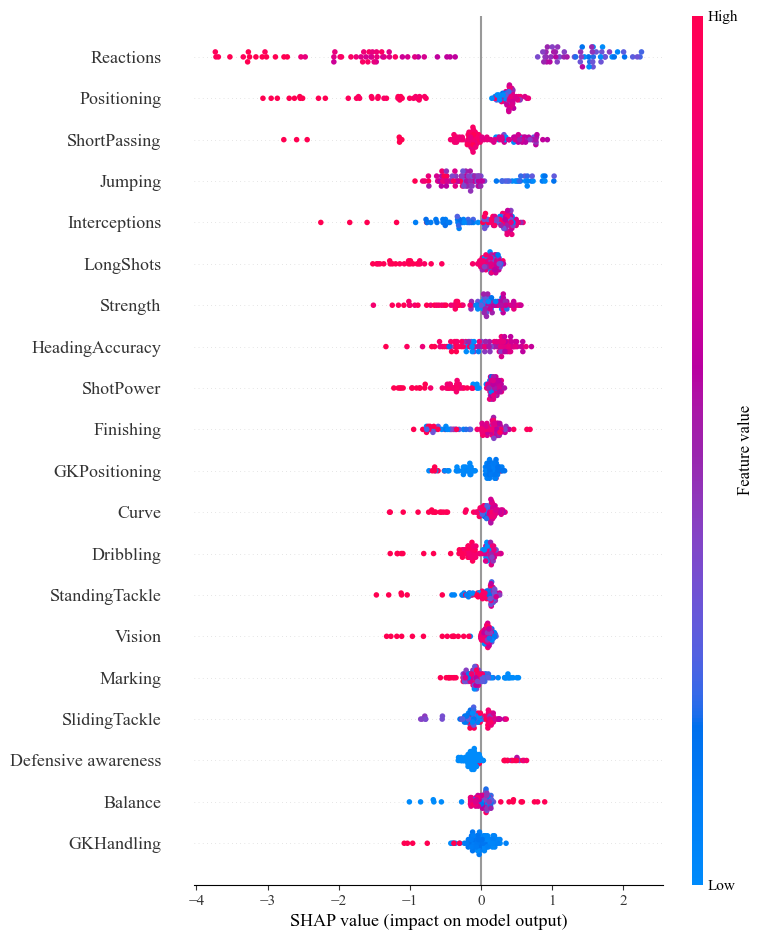

In [153]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)

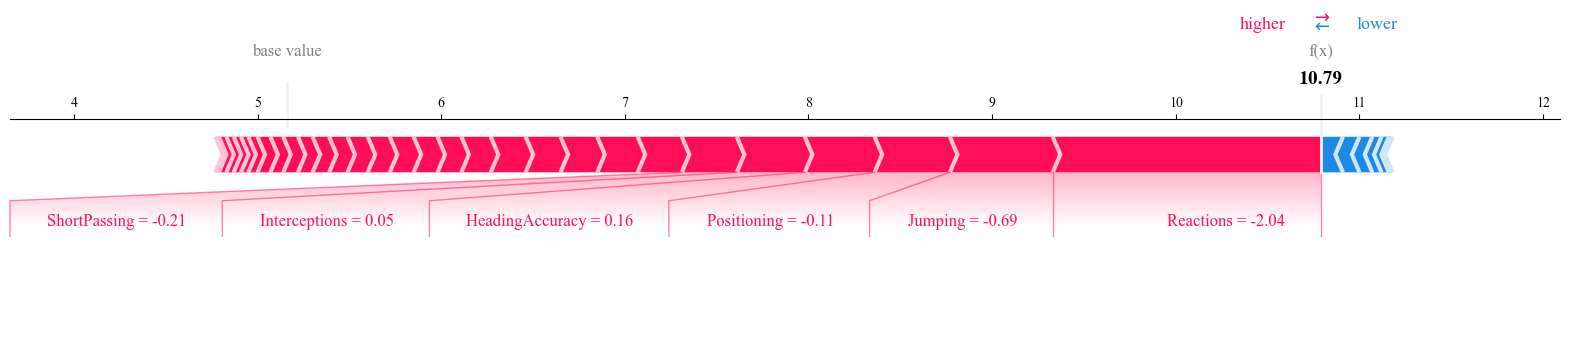

In [154]:
shap.plots.force(np.round(explainer.expected_value[1],2), np.round(shap_values[1][0,:],2), np.round(X_test_scaled_df.iloc[0, :],2), matplotlib = True)

In [155]:
from sklearn.metrics import precision_score
y_score = model.predict_proba(X_test_scaled_df)[:,1]>0.1
pre = np.round(precision_score(y_pred=y_score,y_true=y_test),3)
print("Potentials:",sum(y_score),"Precision:",pre,"------> Correct Potentials",pre*sum(y_score))
X_test[y_score]


Potentials: 93 Precision: 0.849 ------> Correct Potentials 78.957


,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
243627,Y. Adli,17.0,62.0,46.0,60.0,67.0,50.0,74.0,60.0,50.0,65.0,72.0,70.0,69.0,65.0,10.0,14.0,65.0,0.0,56.0,57.0,67.0,59.0,59.0,63.0,53.0,55.0,51.0,59.0,65.0,55.0,59.0,57.0,55.0,14.0,12.0,9.0
232938,T. Tomiyasu,20.0,47.0,27.0,70.0,68.0,22.0,60.0,43.0,35.0,65.0,67.0,67.0,66.0,65.0,5.0,11.0,59.0,72.0,62.0,58.0,37.0,69.0,68.0,81.0,24.0,74.0,69.0,23.0,51.0,37.0,0.0,75.0,74.0,9.0,14.0,6.0
193130,A. Schürrle,21.0,75.0,80.0,65.0,78.0,78.0,86.0,77.0,68.0,67.0,76.0,92.0,85.0,86.0,9.0,12.0,0.0,0.0,80.0,82.0,86.0,78.0,75.0,64.0,88.0,60.0,43.0,79.0,74.0,81.0,23.0,36.0,41.0,7.0,11.0,12.0
199183,Kim Bo Kyung,22.0,73.0,63.0,37.0,74.0,62.0,68.0,72.0,69.0,65.0,68.0,75.0,76.0,74.0,12.0,12.0,0.0,0.0,68.0,67.0,61.0,66.0,67.0,51.0,65.0,54.0,56.0,75.0,71.0,71.0,18.0,17.0,17.0,11.0,14.0,9.0
199151,J. Iturbe,18.0,68.0,72.0,54.0,72.0,66.0,79.0,75.0,68.0,64.0,77.0,85.0,79.0,82.0,6.0,9.0,0.0,0.0,69.0,92.0,64.0,71.0,55.0,35.0,72.0,47.0,23.0,67.0,69.0,65.0,23.0,32.0,31.0,12.0,8.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187961,Paulinho,24.0,63.0,75.0,83.0,82.0,74.0,77.0,65.0,56.0,78.0,83.0,76.0,78.0,70.0,5.0,7.0,0.0,0.0,80.0,64.0,76.0,88.0,92.0,71.0,74.0,73.0,82.0,81.0,80.0,70.0,79.0,79.0,74.0,15.0,15.0,10.0
223898,P. Bernardoni,22.0,12.0,13.0,21.0,28.0,17.0,16.0,15.0,18.0,24.0,25.0,31.0,27.0,21.0,76.0,84.0,55.0,16.0,63.0,34.0,55.0,70.0,36.0,68.0,16.0,29.0,25.0,15.0,21.0,19.0,0.0,12.0,18.0,78.0,74.0,73.0
189484,D. Santon,20.0,77.0,45.0,68.0,73.0,56.0,75.0,73.0,42.0,67.0,77.0,78.0,86.0,66.0,13.0,7.0,0.0,0.0,75.0,49.0,73.0,74.0,86.0,74.0,65.0,75.0,68.0,70.0,67.0,52.0,71.0,75.0,75.0,14.0,9.0,14.0


In [156]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance
if False:
    # Example usage:
    my_model = model_results['LightGBM Classifier']['Model']
    features = plot_feature_importance(my_model, 'LightGBM Classifier')

    my_model = model_results['Random Forest Classifier']['Model']
    features = plot_feature_importance(my_model, 'Random Forest Classifier')
    


    my_model = model_results['XGBoost Classifier']['Model']
    features = plot_feature_importance(my_model, 'XGBoost Classifier')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### evaluate test data

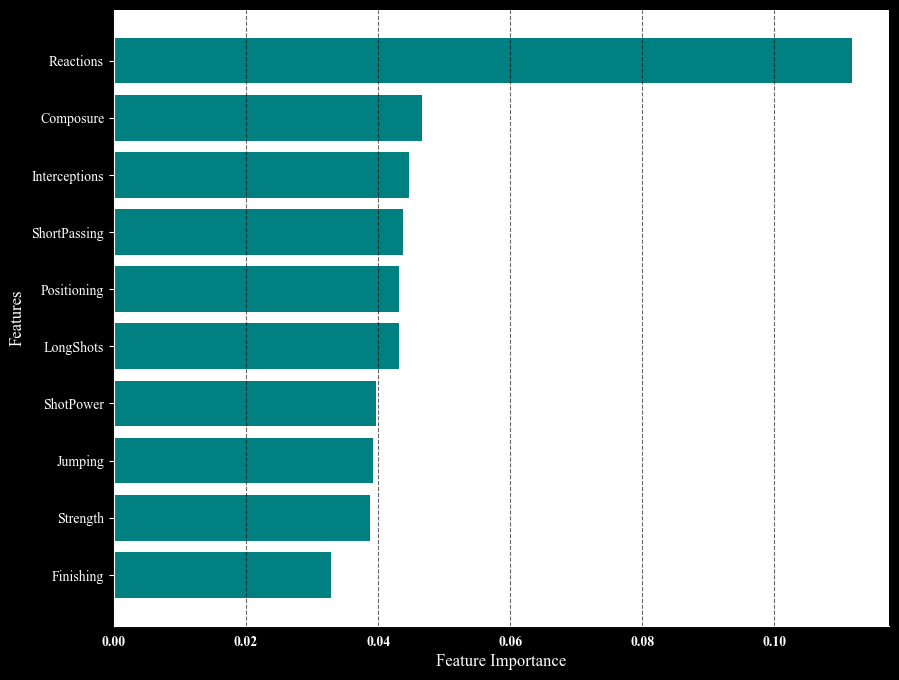

['Reactions',
 'Composure',
 'Interceptions',
 'ShortPassing',
 'Positioning',
 'LongShots',
 'ShotPower',
 'Jumping',
 'Strength',
 'Finishing']

In [157]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [158]:
import pickle

try:
    # Interpret the model using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # Save SHAP values to a pickle file
    with open(f"{model_name}_shap_values.pkl", "wb") as file:
        pickle.dump(shap_values, file)
except:
    print("Fehler bei SHAP",model_name)

In [159]:
import tqdm
df_shap = pd.DataFrame()
i = 0
for i in range(len(shap_values.values)):
    df_shap[i] = shap_values.values[i][:,1]

df_shap = df_shap.T

In [160]:
my_model = model_results[ 'LightGBM Classifier']['Model']
y_pred = pd.DataFrame(my_model.predict_proba(X_test)[:,1],columns=["prediction"],index=y_test.index)

In [161]:
df_shap.index = X_test.index
df_shap.columns = X_test.columns
df_shap["SHAP"] = df_shap.T.sum().values

df_merge = pd.concat([y_pred,df_shap],axis=1)
df_merge = pd.concat([df['Overall'],df_merge],axis=1,join='inner')


In [162]:
df_merge = df_merge.sort_values(by="Aggression",ascending=False).round(3)
df_merge.head(10)

,,Overall,prediction,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,SHAP
ID,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
162240,M. Dembélé,80.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
183899,P. Piatti,78.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
209780,S. Schrijvers,61.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
190264,Iago Falqué,74.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
189963,W. Bony,80.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
188935,O. Assaidi,76.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
186200,F. Borini,72.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
171833,D. Sturridge,83.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33
190544,A. Ljajić,79.0,0.002,-0.059,-0.165,-0.426,-0.689,-1.256,0.04,-0.708,-0.361,-0.054,-0.181,-0.255,0.007,-0.031,0.01,-0.077,0.034,0.005,0.579,-2.548,0.351,-0.613,-0.282,-0.064,-0.388,-0.633,-0.342,-0.432,-1.649,-0.386,-0.017,-0.21,-0.4,0.021,0.13,-0.236,-0.049,-11.33


In [163]:
X_test[X_test.index == df_merge.index[0]]

,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
162240,M. Dembélé,24.0,64.0,66.0,67.0,83.0,76.0,87.0,62.0,54.0,72.0,85.0,85.0,83.0,85.0,15.0,13.0,0.0,0.0,75.0,76.0,84.0,77.0,87.0,86.0,71.0,74.0,48.0,73.0,77.0,64.0,31.0,74.0,58.0,15.0,13.0,10.0


In [164]:
df_shap.sum()/(-df_shap['SHAP'].sum())

Age                   -0.005133
Crossing              -0.014483
Finishing             -0.037407
HeadingAccuracy       -0.061323
ShortPassing          -0.110541
Volleys                0.003466
Dribbling             -0.062272
Curve                 -0.031865
FKAccuracy            -0.003830
LongPassing           -0.016076
BallControl           -0.022455
Acceleration           0.000599
SprintSpeed           -0.002715
Agility                0.000868
GKPositioning         -0.006524
GKReflexes             0.003005
Composure             -0.003861
Defensive awareness    0.051533
Reactions             -0.224496
Balance                0.031025
ShotPower             -0.053983
Jumping               -0.024882
Stamina               -0.005660
Strength              -0.035024
LongShots             -0.055687
Aggression            -0.030246
Interceptions         -0.037868
Positioning           -0.145165
Vision                -0.033792
Penalties             -0.001450
Marking               -0.017048
Standing

### predict potentials

In [170]:
df
prospects = pd.DataFrame(my_model.predict_proba(df_potentials_scaled_df)[:,1],columns=["prediction"],index=df_potentials.index)
# TODO: SHAP VALUES FOR
# df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = True).head(50)

,,prediction
ID,Name,
241637,A. Tchouaméni,0.011463
231478,L. Martínez,0.014326
240130,Éder Militão,0.074418
224232,N. Barella,0.155264
251517,J. Gvardiol,0.184608
231943,Richarlison,0.186291
240950,Pedro Gonçalves,0.217217
240699,N. De la Cruz,0.258706
232580,Gabriel,0.337459


In [166]:
prospects[prospects.prediction>0.5]

,,prediction
ID,Name,
241096,S. Tonali,0.989066
253004,Ansu Fati,0.999747
246104,R. Gravenberch,0.992671
243812,Rodrygo,0.749542
255253,Vitinha,0.924327
...,...,...
240273,E. Smith Rowe,0.999950
232229,J. Bijlow,0.993986
231936,B. White,0.613382


In [167]:
df_prospect.loc[240243][["potential_age","max_potential"	,"Age","FIFA","Overall"]]

,potential_age,max_potential,Age,FIFA,Overall
Name,,,,,
Matheus Cunha,21.0,87.0,21.0,2021,78.0


In [168]:
prospects.value_counts()

prediction
0.011463      1
0.014326      1
0.999940      1
0.999938      1
0.999936      1
             ..
0.991831      1
0.990916      1
0.989876      1
0.989276      1
0.999988      1
Name: count, Length: 120, dtype: int64

In [169]:
prospects.sort_values('prediction',ascending=False).round(3).value_counts()

prediction
1.000         63
0.999          9
0.998          3
0.993          3
0.989          3
0.997          2
0.994          2
0.992          2
0.983          1
0.907          1
0.924          1
0.948          1
0.972          1
0.990          1
0.985          1
0.986          1
0.845          1
0.991          1
0.995          1
0.891          1
0.011          1
0.014          1
0.769          1
0.074          1
0.155          1
0.185          1
0.186          1
0.217          1
0.259          1
0.337          1
0.341          1
0.440          1
0.465          1
0.468          1
0.554          1
0.613          1
0.667          1
0.673          1
0.700          1
0.750          1
0.807          1
Name: count, dtype: int64